## This notebook was created by Jan Stasinski for Stasinski et al. 2024 to perform the relevant FCD analysis.

In [26]:
# load libraries
import sys
import numpy as np
import scipy.io as sio
import scipy.signal as sig
from tvb.simulator.lab import *
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy import signal
from scipy.stats import levy_stable
import string

import pandas as pd
import matplotlib
import matplotlib.patches as patches
sys.path.append('/Users/Documents/Prywata/code_samples/py_scipts')

from supplementary_functions import *

from matplotlib.lines import Line2D
plt.rcParams["text.usetex"] = True

In [27]:
SC_LOC = '/Users/jansta/fic_jansen/HCP_mats/'
DATA_LOC = '/Users/jansta/fic_jansen/stability_analysis/paper_sims/paper_hcp_sims/y0_072/'
PLOT_LOC = '/Users/jansta/fic_jansen/stability_analysis/paper_plots/XI_plots/'
#FCD_DATA = '/Users/jansta/fic_jansen/stability_analysis/FCD_data/'
FCD_LOC = '/Users/jansta/fic_jansen/generic_FCD/'


## set the values for FCD analysis
FCDwin = 83 # in TR
FCDinc = 1 # in TR ( slide by )
TR = 0.72 # in secs

save_the_plots = False
lat_y0t = '$y_{{0}}^{{\\mathrm{{target}}}}$'
PanelLettersUpper = np.array([rf"${{\bf {alpha}}}$" for alpha in string.ascii_uppercase[:25]], dtype=object)
PanelLettersNumbersUpper = np.array(
    [[fr"{{\bf {alpha}{i + 1}}}" for alpha in string.ascii_uppercase[:10]] for i in
     range(12)])

### loading the simulated data:


In [28]:
sim_BOLD_dict = np.load(DATA_LOC + 'bold_only_postFIC_data.npy', allow_pickle=True).item()
sim_BOLD_dict_nf  = np.load(DATA_LOC + 'bold_only_noFIC_data.npy',  allow_pickle=True).item()

In [29]:
sim_BOLD_dict['0.1']['0'].shape

(2490, 2, 84, 1)

In [43]:
load_data=True
if not load_data:
    fcd_dict = {}
    for ydx, (y0, g_dict) in enumerate(sim_BOLD_dict.items()):
        fcd_dict[y0] = {}
        for gc, bold in g_dict.items():
            fcd_dict[y0][gc] = {}
            bv = bold[15:,0,:,0]
            fcd = FCDFromTimeSeries(bv, FCDwin, FCDinc)
            fcd_dist, fcd_dist_bins = FCDDistribution(FCD=fcd, bins=np.linspace(-1, 1, 101))
            fcd_dict[y0][gc]['fcd'] = fcd
            fcd_dict[y0][gc]['fcd_dist'] = fcd_dist
    np.save(DATA_LOC +  'simulated_FCD_data_XI_noZ.npy', fcd_dict, allow_pickle=True)
else:
    fcd_dict = np.load(DATA_LOC +  'simulated_FCD_data_XI_noZ.npy', allow_pickle=True).item()
    fcd_dist_bins = np.array([-1.  , -0.98, -0.96, -0.94, -0.92, -0.9 , -0.88, -0.86, -0.84,
       -0.82, -0.8 , -0.78, -0.76, -0.74, -0.72, -0.7 , -0.68, -0.66,
       -0.64, -0.62, -0.6 , -0.58, -0.56, -0.54, -0.52, -0.5 , -0.48,
       -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34, -0.32, -0.3 ,
       -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16, -0.14, -0.12,
       -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,
        0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,  0.22,  0.24,
        0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,  0.4 ,  0.42,
        0.44,  0.46,  0.48,  0.5 ,  0.52,  0.54,  0.56,  0.58,  0.6 ,
        0.62,  0.64,  0.66,  0.68,  0.7 ,  0.72,  0.74,  0.76,  0.78,
        0.8 ,  0.82,  0.84,  0.86,  0.88,  0.9 ,  0.92,  0.94,  0.96,
        0.98,  1.  ])


y0s = list(fcd_dict.keys())
#fcd_dict['0.007']['10']['fcd']

In [44]:
load_data=True
if not load_data:
    fcd_dict_nf = {}
    for ydx, (y0, g_dict) in enumerate(sim_BOLD_dict_nf.items()):
        fcd_dict_nf[y0] = {}
        for gc, bold in g_dict.items():
            fcd_dict_nf[y0][gc] = {}
            bv = bold[15:,0,:,0]
            fcd = FCDFromTimeSeries(bv, FCDwin, FCDinc)
            fcd_dist, fcd_dist_bins = FCDDistribution(FCD=fcd, bins=np.linspace(-1, 1, 101))
            fcd_dict_nf[y0][gc]['fcd'] = fcd
            fcd_dict_nf[y0][gc]['fcd_dist'] = fcd_dist
    np.save(DATA_LOC +  'simulated_nf_FCD_data_XI_noZ.npy', fcd_dict_nf, allow_pickle=True)
else:
    fcd_dict_nf = np.load(DATA_LOC +  'simulated_nf_FCD_data_XI_noZ.npy', allow_pickle=True).item()

#fcd_dict_nf['0.007']['10']['fcd']

### Loading the empirical distribution

dict_keys(['__header__', '__version__', '__globals__', 'edges', 'overall_hist'])
(100,)


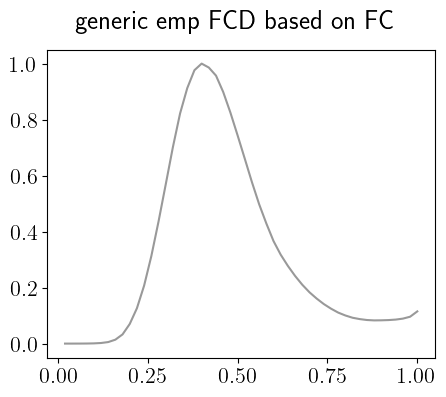

In [45]:
emp_FCD = sio.loadmat(FCD_LOC + 'new_overall_hist_FCD_83TR.mat')
print(emp_FCD.keys())

emp_FCD_bins = emp_FCD['edges'][0][1:]#[50:] 
emp_FCD_dist = emp_FCD['overall_hist'][0]#[49:]
print(emp_FCD_dist.shape)
fig, ax = plt.subplots(1,figsize=(5, 4))
fig.suptitle('generic emp FCD based on FC')
# im = ax[0].imshow(emp_FCD_fcd)
ax.plot(emp_FCD_bins[50:], emp_FCD_dist[50:]/ np.max(emp_FCD_dist[50:]), 'k', alpha=0.4)

### best fitting simulations selection:

In [46]:
#post: 
y01 = str(0.007)
gc1 = str(18)

y03 = str(0.007)
gc3 = str(20)

y02 = str(0.01)
gc2 = str(11)
#no:
y01n = str(0.007)
gc1n = str(9)

y02n = str(0.004)
gc2n = str(18)

plt.rcParams.update({'font.size': 15})


thresh = 95

### Plotting the FCD data and distributions:

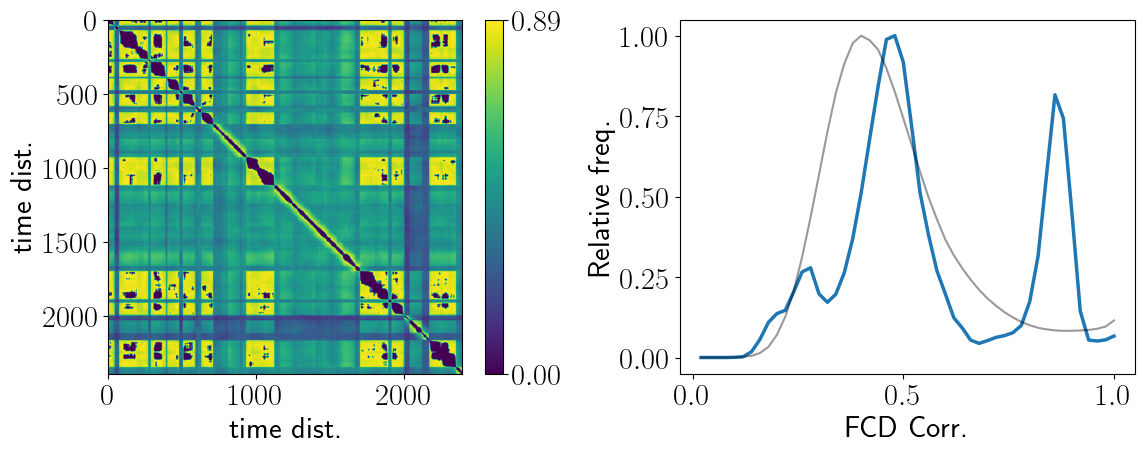

In [47]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(1,2,figsize=(12, 5))
#fig.suptitle('FCD fit')

# Calculate the 99th percentile
threshold_value = np.percentile(fcd_dict[y01][gc1]['fcd'], thresh)

sub = 0
#sub = threshold_value
# Threshold the values at the Nth percentile
fcd_thresholded = np.where(fcd_dict[y01][gc1]['fcd'] > threshold_value, sub, fcd_dict[y01][gc1]['fcd'])
vmx =np.max(fcd_thresholded)
im = ax[0].imshow(fcd_thresholded)
#im = ax[0].imshow(fcd_dict[y01][gc1]['fcd'])

#fig.colorbar(im)
cb = fig.colorbar(im, ax=ax[0], shrink=1)
im.set_clim(0, vmx) 
cb.set_ticks(np.round([0, vmx],2))
ax[1].plot(fcd_dist_bins[51:], fcd_dict[y01][gc1]['fcd_dist'][50:] / np.max(fcd_dict[y01][gc1]['fcd_dist'][50:]),linewidth=2.5)
ax[1].plot(emp_FCD_bins[50:], emp_FCD_dist[50:]/ np.max(emp_FCD_dist[50:]), 'k', alpha=0.4)


ax[0].set_xlabel('time dist.')
ax[0].set_ylabel('time dist.')
ax[1].set_xlabel('FCD Corr.')
ax[1].set_ylabel('Relative freq.')

plt.tight_layout()

if save_the_plots:
    fig.savefig(PLOT_LOC+ f'best_sim_FCD_based_on_FCD_fit_th{thresh}.jpg')

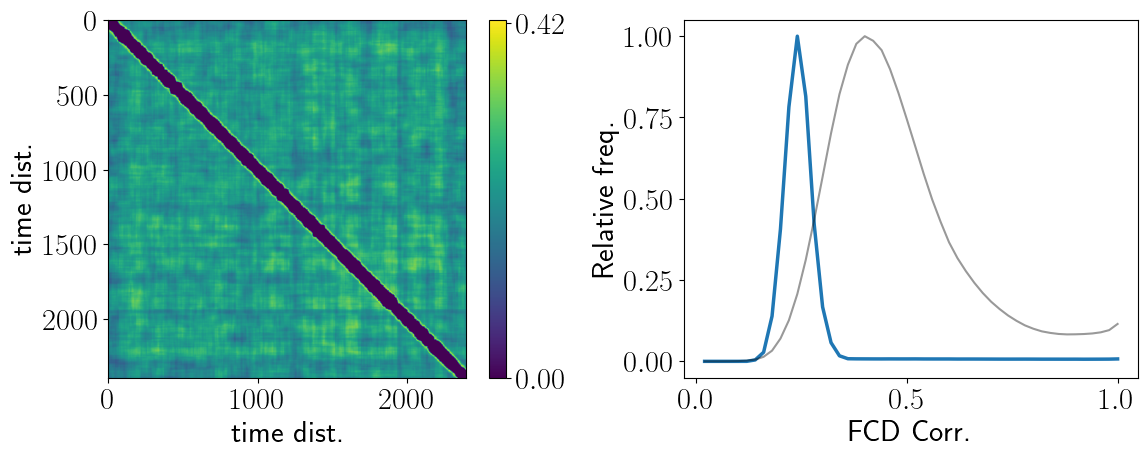

In [48]:
fig, ax = plt.subplots(1,2,figsize=(12, 5))

zero = 0
threshold_value = np.percentile(fcd_dict[y03][gc3]['fcd'], thresh)
# Threshold the values at the Nth percentile
fcd_thresholded = np.where(fcd_dict[y03][gc3]['fcd'] > threshold_value,  sub, fcd_dict[y03][gc3]['fcd'])
vmx =np.max(fcd_thresholded)
im = ax[0].imshow(fcd_thresholded)
#im = ax[0].imshow(fcd_dict[y03][gc3]['fcd'])
cb = fig.colorbar(im, ax=ax[0])
im.set_clim(0, vmx) 
cb.set_ticks(np.round([0, vmx],2))
ax[1].plot(fcd_dist_bins[51:], fcd_dict[y03][gc3]['fcd_dist'][50:] / np.max(fcd_dict[y03][gc3]['fcd_dist'][50:]),linewidth=2.5)
ax[1].plot(emp_FCD_bins[50:], emp_FCD_dist[50:]/ np.max(emp_FCD_dist[50:]), 'k', alpha=0.4)
ax[0].set_xlabel('time dist.')
ax[0].set_ylabel('time dist.')
ax[1].set_xlabel('FCD Corr.')
ax[1].set_ylabel('Relative freq.')

plt.tight_layout()
if save_the_plots:
    fig.savefig(PLOT_LOC+ f'best_sim_FCD_based_on_FC_fit_th{thresh}.jpg')

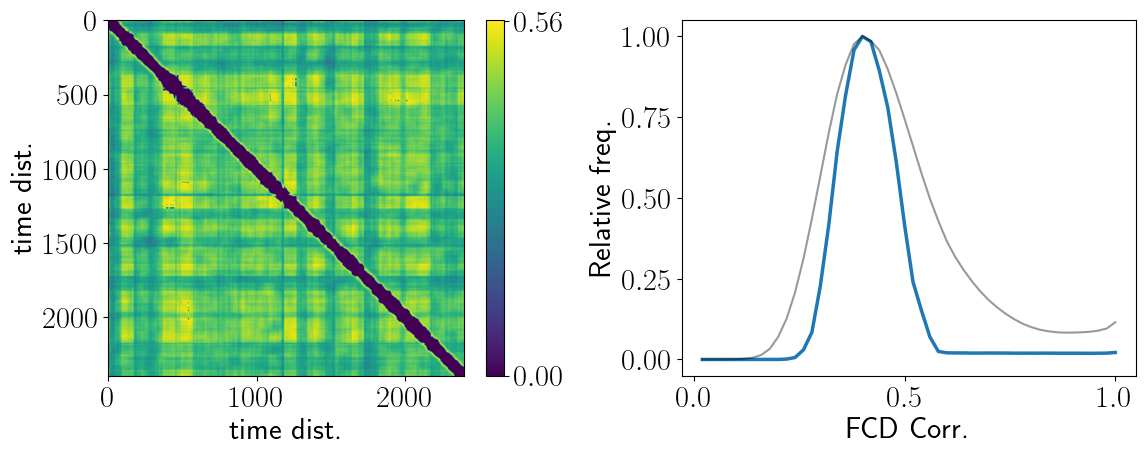

In [49]:
fig, ax = plt.subplots(1,2,figsize=(12, 5))
#fig.suptitle('MMF fit')


threshold_value = np.percentile(fcd_dict[y02][gc2]['fcd'], thresh)
# Threshold the values at the Nth percentile
fcd_thresholded = np.where(fcd_dict[y02][gc2]['fcd'] > threshold_value,  sub, fcd_dict[y02][gc2]['fcd'])
vmx =np.max(fcd_thresholded)
im = ax[0].imshow(fcd_thresholded)

#im = ax[0].imshow(fcd_dict[y02][gc2]['fcd'])
cb = fig.colorbar(im, ax=ax[0])
im.set_clim(0, vmx) 
cb.set_ticks(np.round([0, vmx],2))
ax[1].plot(fcd_dist_bins[51:], fcd_dict[y02][gc2]['fcd_dist'][50:] / np.max(fcd_dict[y02][gc2]['fcd_dist'][50:]) ,linewidth=2.5)
ax[1].plot(emp_FCD_bins[50:], emp_FCD_dist[50:]/ np.max(emp_FCD_dist[50:]), 'k', alpha=0.4)

ax[0].set_xlabel('time dist.')
ax[0].set_ylabel('time dist.')
ax[1].set_xlabel('FCD Corr.')
ax[1].set_ylabel('Relative freq.')
fig.tight_layout()

if save_the_plots:
    fig.savefig(PLOT_LOC+ f'best_sim_FCD_based_on_MMF_fit_th{thresh}.jpg')


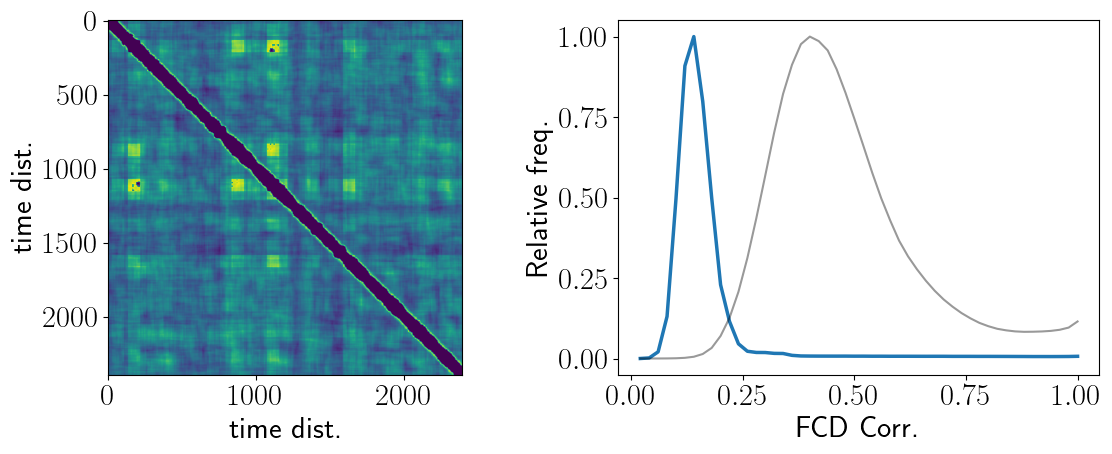

In [50]:
fig, ax = plt.subplots(1,2,figsize=(12, 5))
#fig.suptitle('no-FIC FC')

threshold_value = np.percentile(fcd_dict_nf[y01n][gc1n]['fcd'], thresh)
# Threshold the values at the Nth percentile
fcd_thresholded = np.where(fcd_dict_nf[y01n][gc1n]['fcd'] > threshold_value,  sub, fcd_dict_nf[y01n][gc1n]['fcd'])
vmx =np.max(fcd_thresholded)
im = ax[0].imshow(fcd_thresholded)
#im = ax[0].imshow(fcd_dict_nf[y01n][gc1n]['fcd'])
im.set_clim(0, vmx) 
cb.set_ticks(np.round([0, vmx],2))
ax[1].plot(fcd_dist_bins[51:], fcd_dict_nf[y01n][gc1n]['fcd_dist'][50:] / np.max(fcd_dict_nf[y01n][gc1n]['fcd_dist'][50:] ),linewidth=2.5)
ax[1].plot(emp_FCD_bins[50:], emp_FCD_dist[50:]/ np.max(emp_FCD_dist[50:]), 'k', alpha=0.4)

ax[0].set_xlabel('time dist.')
ax[0].set_ylabel('time dist.')
ax[1].set_xlabel('FCD Corr.')
ax[1].set_ylabel('Relative freq.')
fig.tight_layout()

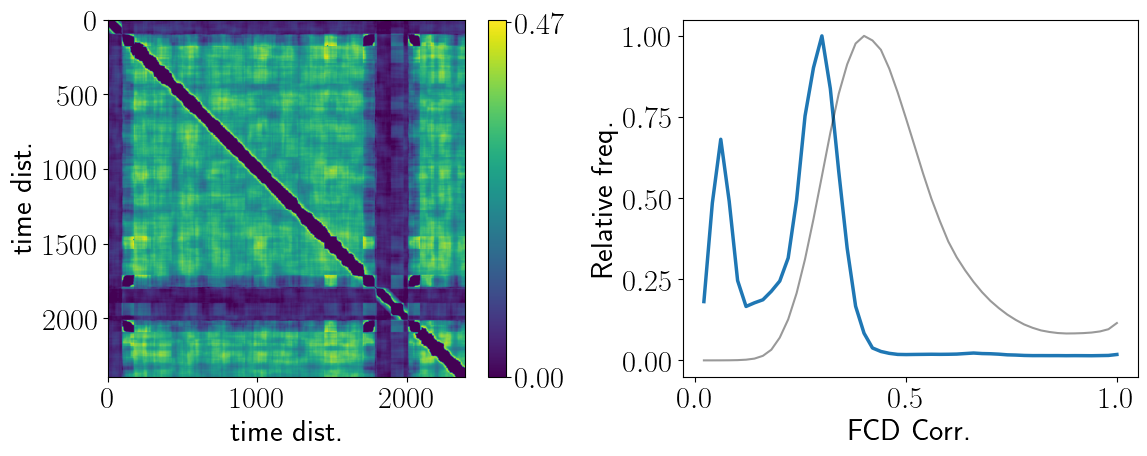

In [51]:
fig, ax = plt.subplots(1,2,figsize=(12, 5))
#fig.suptitle('noFIC best FCD based on FCD fit:')

threshold_value = np.percentile(fcd_dict_nf[y02n][gc2n]['fcd'], thresh)
# Threshold the values at the Nth percentile
fcd_thresholded = np.where(fcd_dict_nf[y02n][gc2n]['fcd'] > threshold_value,  sub, fcd_dict_nf[y02n][gc2n]['fcd'])
vmx =np.max(fcd_thresholded)
im = ax[0].imshow(fcd_thresholded)
#im = ax[0].imshow(fcd_dict_nf[y02n][gc2n]['fcd'])
cb = fig.colorbar(im, ax=ax[0])
im.set_clim(0, vmx) 
cb.set_ticks(np.round([0, vmx],2))
ax[1].plot(fcd_dist_bins[51:], fcd_dict_nf[y02n][gc2n]['fcd_dist'][50:]/np.max(fcd_dict_nf[y02n][gc2n]['fcd_dist'][50:]),linewidth=2.5)
ax[1].plot(emp_FCD_bins[50:], emp_FCD_dist[50:]/ np.max(emp_FCD_dist[50:]), 'k', alpha=0.4)
ax[0].set_xlabel('time dist.')
ax[0].set_ylabel('time dist.')
ax[1].set_xlabel('FCD Corr.')
ax[1].set_ylabel('Relative freq.')
fig.tight_layout()
if save_the_plots:
    fig.savefig(PLOT_LOC+ f'best_noFIC_sim_FCD_based_on_FCD_fit_th{thresh}.jpg')

### Creating a neat plot for the paper:

['best_sim_FCD_based_on_FC_fit_th95.jpg', 'best_sim_FCD_based_on_FCD_fit_th95.jpg', 'best_sim_FCD_based_on_MMF_fit_th95.jpg', 'best_noFIC_sim_FCD_based_on_FCD_fit_th95.jpg']


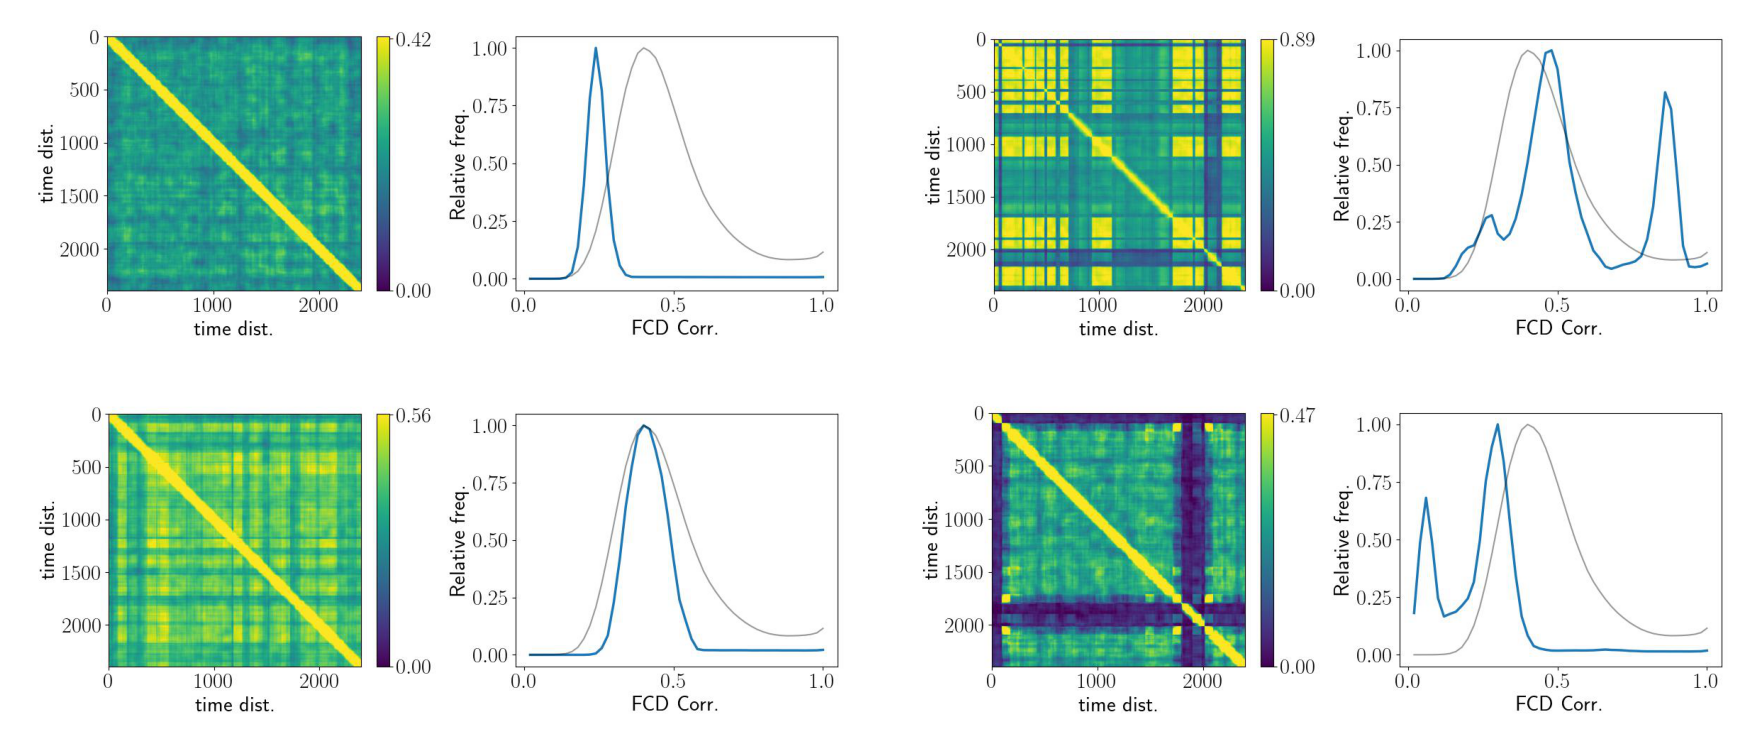

In [52]:
thresh = 95
# # Path to the directory containing JPG files
image_folder = PLOT_LOC + '/FCDs/'


# image_files = []
# for file in on.listdir(image_folder):
#     if file.endswith(f'{thresh}.jpg'):
#         image_files.append(file)
                     
image_files = [f'best_sim_FCD_based_on_FC_fit_th{thresh}.jpg',f'best_sim_FCD_based_on_FCD_fit_th{thresh}.jpg', 
            f'best_sim_FCD_based_on_MMF_fit_th{thresh}.jpg',f'best_noFIC_sim_FCD_based_on_FCD_fit_th{thresh}.jpg']

print(image_files)
fig, axes = plt.subplots(2, 2, figsize=(18, 8))
axes = axes.ravel()

for i, ax in enumerate(axes):
        #image_path = os.path.join(image_folder, image_files[i])
    image = plt.imread(image_folder + image_files[i])
    ax.imshow(image)
    ax.axis('off')



#AddPanelLabels(axes, label=PanelsLettersUpper.T, fontsize=26)
fig.tight_layout()
if save_the_plots:
    fig.savefig(PLOT_LOC + f'best_4_FCDs_th{thresh}0.png')


### Preparing  and  plotting the wheatmap for the whole dataset:

In [53]:
kss_mat = np.zeros([24,30])

for ydx,  (y0t, gc_dict) in enumerate(fcd_dict.items()):

    for gdx, (gc, fcd_data) in enumerate(gc_dict.items()):
        sd_norm = np.sort(fcd_data['fcd_dist'][50:] / np.max(fcd_data['fcd_dist'][50:]))
        ed_norm = np.sort(emp_FCD_dist[50:] / np.max(emp_FCD_dist[50:]))

        ks = compute_ks_distance(sd_norm,  ed_norm,  one_samp=True)[0]
        kss_mat[ydx,gdx] = ks

kss_mat = np.round(kss_mat,4)

for ydx,  (y0t, gc_dict) in enumerate(fcd_dict_nf.items()):
    for gdx, (gc, fcd_data) in enumerate(gc_dict.items()):
        sd_norm = np.sort(fcd_data['fcd_dist'][50:] / np.max(fcd_data['fcd_dist'][50:]))
        ed_norm = np.sort(emp_FCD_dist[50:] / np.max(emp_FCD_dist[50:]))
        ks = compute_ks_distance(sd_norm,  ed_norm,  one_samp=True)[0]
        kss_mat[ydx+12,gdx] = ks

    print(y0t, np.mean(kss_mat[ydx,:]),np.mean(kss_mat[ydx+12,:]))

np.save(DATA_LOC + 'kss_mat_IX_sort.npy', kss_mat, allow_pickle=True)




0.001 0.18333333333333326 0.18333333333333332
0.004 0.19133333333333338 0.25666666666666665
0.007 0.29866666666666664 0.26199999999999996
0.01 0.29666666666666675 0.22266666666666665
0.013 0.268 0.20999999999999996
0.016 0.25399999999999995 0.20666666666666658
0.0189 0.26 0.20533333333333328
0.1 0.2533333333333333 0.21666666666666667
0.11 0.18933333333333335 0.19733333333333328
0.12 0.18399999999999997 0.18866666666666673
0.13 0.18533333333333332 0.1833333333333333
0.14 0.18199999999999997 0.18466666666666667


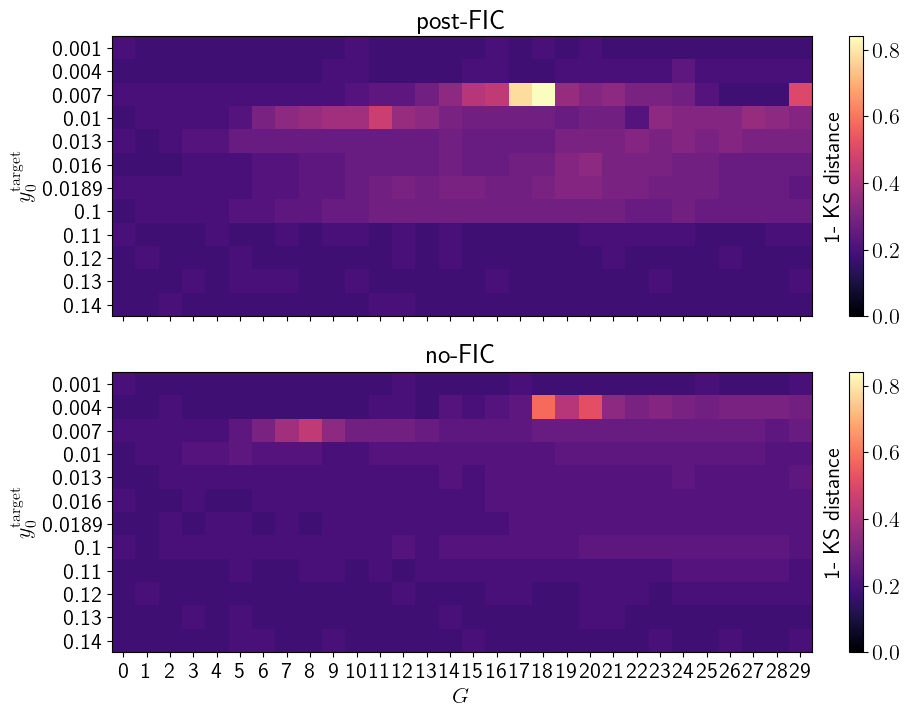

In [54]:
plt.rcParams.update({'font.size': 16})

gcs = range(30)
fig, axs = plt.subplots(2, figsize=(12, 8), sharex=True, sharey=True)
vmin = np.min(kss_mat)
vmin = 0
vmax = np.max(kss_mat)
for idx, ax in enumerate(axs):
    if idx == 0:
        im = ax.imshow(kss_mat[:12,:], vmin=vmin, vmax=vmax, cmap='magma')
        ax.set_ylabel("{\sffamily $y_{0}^{\mathrm{target}}$}%")
        ax.set_yticks(range(12));
        ax.set_yticklabels(y0s)
        ax.set_xticks(range(len(gcs)));
        ax.set_xticklabels(gcs)
        ax.set_ylabel(f'{lat_y0t}')
        ax.set_title(f'post-FIC')
        
        #ax.scatter(dot_idxs[idx], range(12), color='red', s=30, marker='.')
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('1- KS distance')
        cbar.ax.yaxis.set_label_position('left')
    if idx == 1:
        im2 = ax.imshow(kss_mat[12:,:], vmin=vmin, vmax=vmax,  cmap='magma')
        ax.set_ylabel("{\sffamily $y_{0}^{\mathrm{target}}$}%")
        ax.set_title(f'no-FIC')
        ax.set_ylabel(f'{lat_y0t}')
        ax.set_xlabel('$G$')
        #ax.scatter(dot_idxs[idx], range(12), color='red', s=30, marker='.')
        cbar = plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('1- KS distance')
        cbar.ax.yaxis.set_label_position('left')
#AddPanelLabels(axs, label=PanelsLettersUpper.T, fontsize=20)

if save_the_plots:
    fig.savefig(PLOT_LOC + 'heatmap_gc_X_y0_KS_distances.jpg')

In [55]:
y0_KSDs = {}
y0_KSDs_nf = {}
y0s = [0.001, 0.004, 0.007, 0.01, 0.013, 0.016, 0.0189, 0.1, 0.11, 0.12, 0.13, 0.14]
y0_KSDs = {y0: [] for y0 in y0s}
y0_KSDs_nf = {y0: [] for y0 in y0s}
kss_mat

for i in range(2):
    for ydx, y0 in enumerate(y0s):
        if i == 0:
            y0_KSDs[y0] = np.max(kss_mat[ydx,:])
            print(y0, np.max(kss_mat[ydx,:]))
        if i == 1:
            y0_KSDs_nf[y0] = np.max(kss_mat[ydx+12,:])
            print(y0, np.max(kss_mat[ydx+12,:]))

print(y0_KSDs.keys())
            

0.001 0.2
0.004 0.24
0.007 0.84
0.01 0.46
0.013 0.32
0.016 0.34
0.0189 0.32
0.1 0.28
0.11 0.2
0.12 0.2
0.13 0.2
0.14 0.2
0.001 0.19999999999999996
0.004 0.5800000000000001
0.007 0.43999999999999995
0.01 0.24
0.013 0.24
0.016 0.21999999999999997
0.0189 0.21999999999999997
0.1 0.24
0.11 0.21999999999999997
0.12 0.19999999999999996
0.13 0.19999999999999996
0.14 0.19999999999999996
dict_keys([0.001, 0.004, 0.007, 0.01, 0.013, 0.016, 0.0189, 0.1, 0.11, 0.12, 0.13, 0.14])


[0.001, 0.004, 0.007, 0.01, 0.013, 0.016, 0.0189]


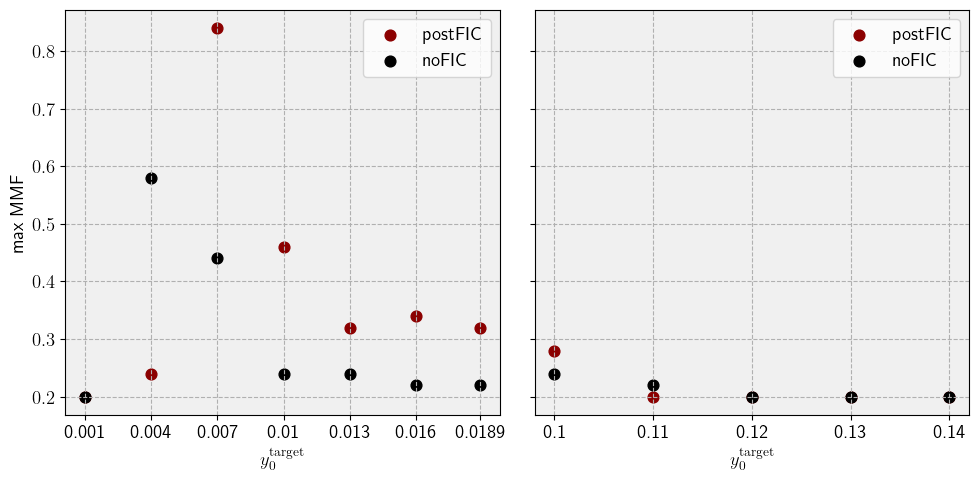

In [56]:
x11 = [i for i in list(y0_KSDs.keys()) if i < 0.02]
print(x11)
x12 = [i for i in list(y0_KSDs.keys()) if i > 0.09]  # Values in the range 0-0.02
y11 = [y0_KSDs[i] for i in list(y0_KSDs.keys()) if i < 0.02]
y12 = [y0_KSDs[i] for i in list(y0_KSDs.keys()) if i > 0.09]
x21 = [i for i in list(y0_KSDs_nf.keys()) if i < 0.02]
x22 = [i for i in list(y0_KSDs_nf.keys()) if i > 0.09]  # Values in the range 0-0.02
y21 = [ y0_KSDs_nf[i]  for i in list(y0_KSDs_nf.keys()) if i < 0.02]
y22 = [ y0_KSDs_nf[i]  for i in list(y0_KSDs_nf.keys()) if i > 0.09]

plt.rcParams.update({'font.size': 13.5})
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
axs[0].scatter(x11 , y11 , color='darkred', s=60 )
axs[0].scatter(x21 , y21 , color='k', s=60 )

axs[1].scatter(x12 , y12 , color='darkred', s=60 )
axs[1].scatter(x22 , y22 , color='k', s=60 )

axs[0].set_ylabel('max MMF')
axs[0].set_xticks([0.001, 0.004, 0.007, 0.01, 0.013, 0.016, 0.0189])
axs[0].set_xticklabels([0.001, 0.004, 0.007, 0.01, 0.013, 0.016, 0.0189])


axs[1].set_xticks([0.1, 0.11, 0.12, 0.13, 0.14])
axs[1].set_xticklabels([0.1, 0.11, 0.12, 0.13, 0.14])


for ax in axs: 
    ax.grid(ls='--')
    ax.set_xlabel(f'{lat_y0t}')
    ax.legend(['postFIC', 'noFIC'],loc='upper right')
    ax.set_facecolor('#F0F0F0')


fig.tight_layout()

fig.savefig(PLOT_LOC + 'postFIC_vs_noFIC_MMF_score_per_y0t_twoplot.jpg')